## Convolution 1D

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from activation import ReLU, TanH, Sigmoid
from convolution.avgPool1D import AvgPool1D
from convolution.conv1D import Conv1D, ConvTranspose1D, DoubleConv1D
from convolution.flatten import Flatten
from convolution.maxPool1D import MaxPool1D
from enums import GradientDescentMode
from linear import Linear
from loss import CELoss, MSELoss
from module import Module
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [3]:
plt.style.use('seaborn-whitegrid')

### Série temporelle : Air Passengers

In [4]:
import pandas as pd

In [5]:
air_passengers_df = pd.read_csv('data/AirPassengers.csv')
air_passengers_df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [6]:
data = air_passengers_df['#Passengers'].values.astype('float32')

# Normalisation des données
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.reshape(-1, 1))
data[:10]

array([[-0.9691119 ],
       [-0.94594586],
       [-0.89189184],
       [-0.9034748 ],
       [-0.9343629 ],
       [-0.8803088 ],
       [-0.8301158 ],
       [-0.8301158 ],
       [-0.8764478 ],
       [-0.9420849 ]], dtype=float32)

In [7]:
# Préparation des données en séquences
seq_len = 12
x_data = []
y_data = []
for i in range(len(data)-seq_len-1):
    x = data[i:(i+seq_len)]
    y = data[i+seq_len]
    x_data.append(x)
    y_data.append(y)

x_data = np.array(x_data)
y_data = np.array(y_data).squeeze()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((104, 12, 1), (27, 12, 1), (104,), (27,))

In [9]:
k_size = 3
c_out = 1

net = Sequential(
    Conv1D(k_size, 1, 1, 1),
    Flatten(),
    Linear(seq_len-k_size+1, c_out)
)

lr = 1e-1
epochs = 1000
loss = MSELoss()

all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    x_train,
    y_train,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    None,
    x_test,
    y_test
)

Train : -----------------------------------
Epoch 100: train loss: 0.13205171649096073 val loss: 0.13471744710818742
Epoch 200: train loss: 0.10063331611528457 val loss: 0.1044170206366415
Epoch 300: train loss: 0.0798662915460339 val loss: 0.08425075588709126
Epoch 400: train loss: 0.06609264343600049 val loss: 0.07076636122210725
Epoch 500: train loss: 0.05691135255772582 val loss: 0.061692607015719575
Epoch 600: train loss: 0.05074643857606334 val loss: 0.05553443105241649
Epoch 700: train loss: 0.04656344874620199 val loss: 0.05130700484399517
Epoch 800: train loss: 0.04368337088439596 val loss: 0.04836104087725094
Epoch 900: train loss: 0.041660492263968334 val loss: 0.04626801328555419
Epoch 1000: train loss: 0.04020223040652938 val loss: 0.04474472493181101
-------------------------------------------


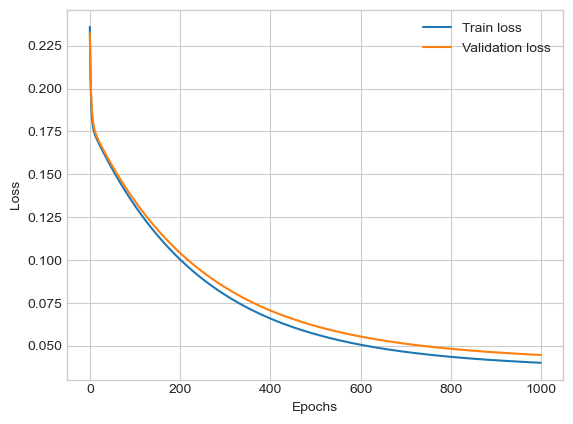

In [10]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Digits

In [4]:
digits = datasets.load_digits()

print('Nombre d exemples :', len(digits.data))
print('Nombre de features :', len(digits.feature_names))
print('Nombre de classes :', len(digits.target_names))

Nombre d exemples : 1797
Nombre de features : 64
Nombre de classes : 10


In [5]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=.2)
print('Données d apprentissage :', X_train.shape, y_train.shape)
print('Données de test :', X_test.shape, y_test.shape)

Données d apprentissage : (1437, 64) (1437,)
Données de test : (360, 64) (360,)


In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_test.shape

((1437, 64, 1), (360, 64, 1))

In [7]:
y_train_onehot = onehot_encoding(y_train, 10)
y_test_onehot = onehot_encoding(y_test, 10)
print('One hot train :', y_train_onehot.shape)
print('One hot test :', y_test_onehot.shape)

One hot train : (1437, 10)
One hot test : (360, 10)


In [8]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

#### Conv1D

In [16]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.1070762696256411 val loss: 0.1491669837268663 val eval_fn: 0.9666666666666667
Epoch 200: train loss: 0.061205771570572866 val loss: 0.10773687052918843 val eval_fn: 0.9722222222222222
Epoch 300: train loss: 0.04252400006545108 val loss: 0.09127224998264603 val eval_fn: 0.975
Epoch 400: train loss: 0.03162846606658231 val loss: 0.08111885119361752 val eval_fn: 0.9722222222222222
Epoch 500: train loss: 0.024492482596393004 val loss: 0.07502086941231635 val eval_fn: 0.975
Epoch 600: train loss: 0.019587246004555955 val loss: 0.07126201677268058 val eval_fn: 0.9777777777777777
Epoch 700: train loss: 0.016055162076083724 val loss: 0.06883623767130931 val eval_fn: 0.9777777777777777
Epoch 800: train loss: 0.013438983573702537 val loss: 0.06716235560562384 val eval_fn: 0.9777777777777777
Epoch 900: train loss: 0.011455150848449811 val loss: 0.06589391968311312 val eval_fn: 0.9777777777777777
Epoch 1000: train loss: 0.0099164

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, X, y):
    y_pred = net(X).argmax(1)
    cm = confusion_matrix(y, y_pred)
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

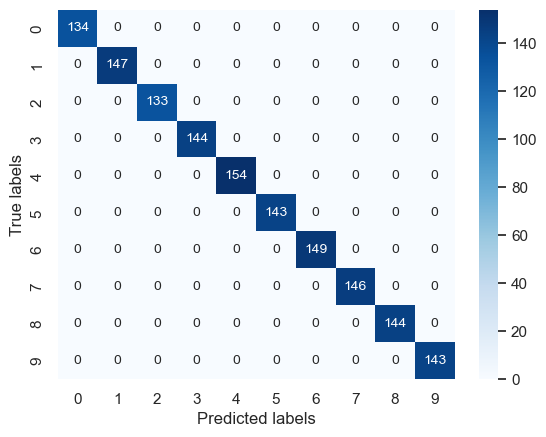

In [18]:
plot_confusion_matrix(net, X_train, y_train)

In [19]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 1.0


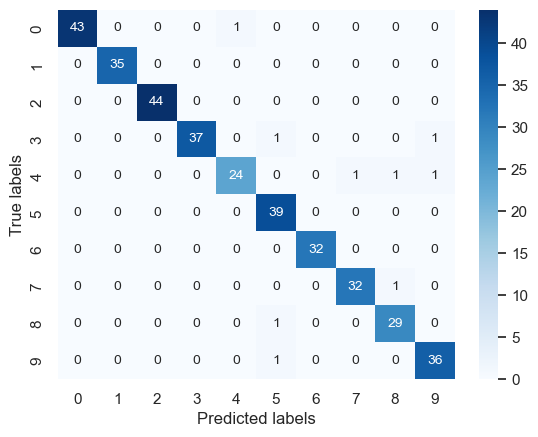

In [20]:
plot_confusion_matrix(net, X_test, y_test)

In [22]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.975


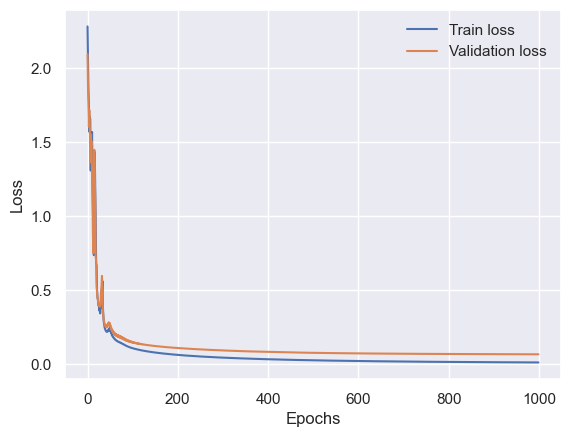

In [23]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

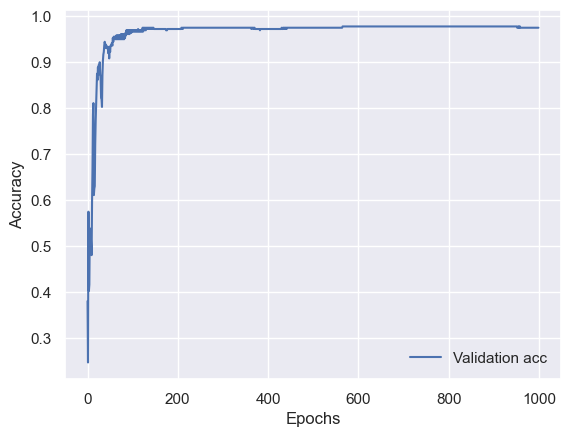

In [24]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Conv Transpose 1D

In [26]:
net = Sequential(
    ConvTranspose1D(3, 1, 32, 1, width=8, height=8),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.12955252217653834 val loss: 0.17797117080044889 val eval_fn: 0.9583333333333334
Epoch 200: train loss: 0.0716134635624877 val loss: 0.12797267787108701 val eval_fn: 0.9722222222222222
Epoch 300: train loss: 0.049436913302529036 val loss: 0.1063355336817109 val eval_fn: 0.9694444444444444
Epoch 400: train loss: 0.03689305071242768 val loss: 0.09241612188740991 val eval_fn: 0.9694444444444444
Epoch 500: train loss: 0.02871206551394424 val loss: 0.08315448679946132 val eval_fn: 0.9722222222222222
Epoch 600: train loss: 0.023052131003787977 val loss: 0.07716387216418447 val eval_fn: 0.975
Epoch 700: train loss: 0.018977514952893407 val loss: 0.07327860395634896 val eval_fn: 0.975
Epoch 800: train loss: 0.015949605022823703 val loss: 0.07049481639516052 val eval_fn: 0.975
Epoch 900: train loss: 0.013638473321234088 val loss: 0.0683637535547778 val eval_fn: 0.975
Epoch 1000: train loss: 0.011830861665941998 val loss: 0.0666

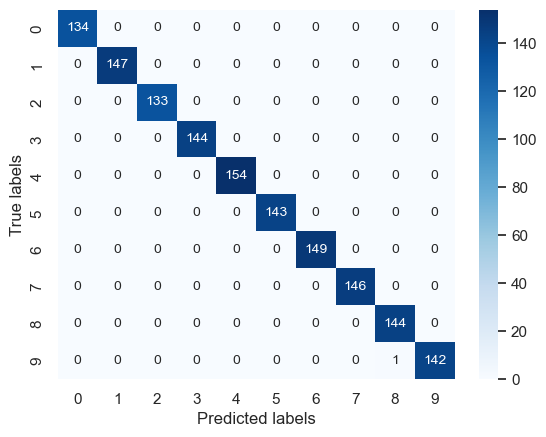

In [27]:
plot_confusion_matrix(net, X_train, y_train)

In [28]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9993041057759221


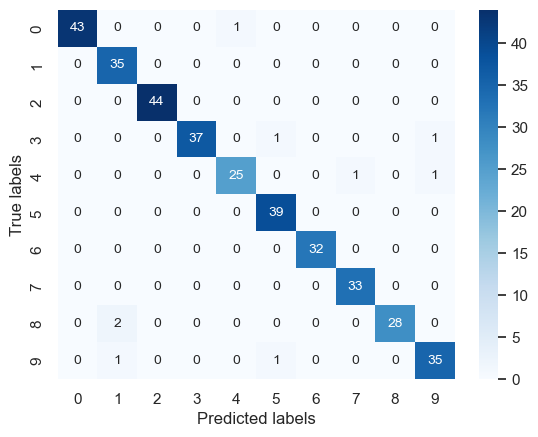

In [29]:
plot_confusion_matrix(net, X_test, y_test)

In [30]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.975


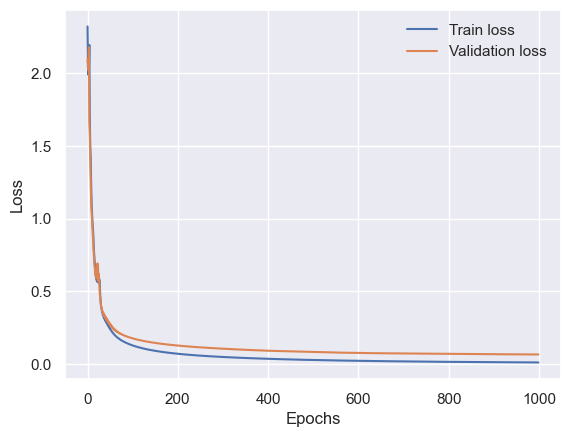

In [31]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

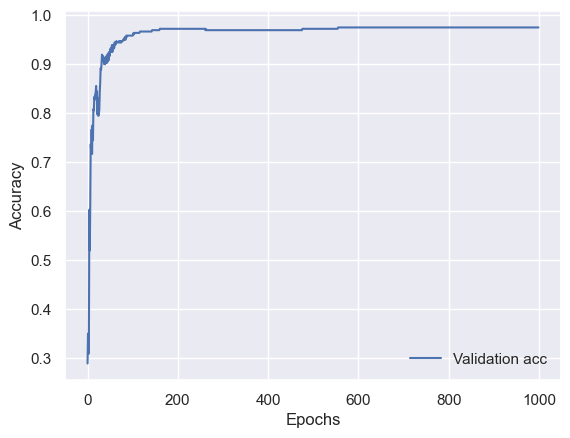

In [32]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Average pooling

In [34]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    AvgPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.1614104290730541 val loss: 0.20351606416008705 val eval_fn: 0.9527777777777777
Epoch 200: train loss: 0.09165746213522204 val loss: 0.14708149172965834 val eval_fn: 0.9694444444444444
Epoch 300: train loss: 0.0677636680207051 val loss: 0.1297424497540742 val eval_fn: 0.9694444444444444
Epoch 400: train loss: 0.05351735787206533 val loss: 0.11903051338732315 val eval_fn: 0.9694444444444444
Epoch 500: train loss: 0.04365210331621853 val loss: 0.11126357739677648 val eval_fn: 0.9694444444444444
Epoch 600: train loss: 0.03627680170000718 val loss: 0.10501077890435187 val eval_fn: 0.9694444444444444
Epoch 700: train loss: 0.03058558822233427 val loss: 0.10024657286641556 val eval_fn: 0.9694444444444444
Epoch 800: train loss: 0.02605818606955424 val loss: 0.09706810059997487 val eval_fn: 0.9666666666666667
Epoch 900: train loss: 0.02243856933397321 val loss: 0.09484047975766635 val eval_fn: 0.9666666666666667
Epoch 1000: tr

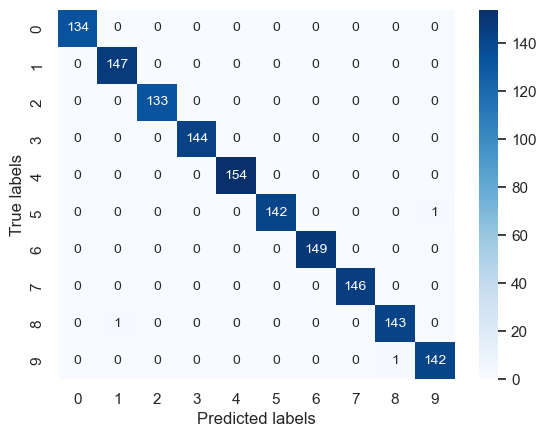

In [35]:
plot_confusion_matrix(net, X_train, y_train)

In [36]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9979123173277662


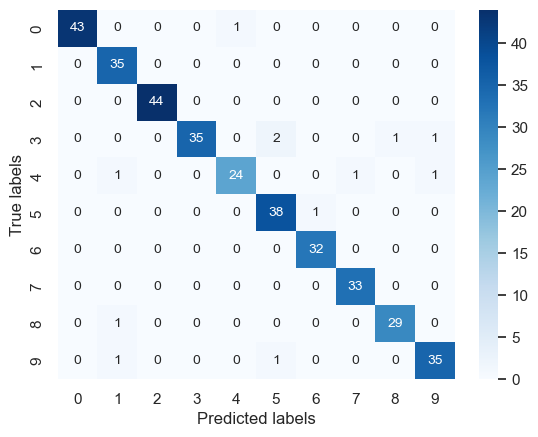

In [37]:
plot_confusion_matrix(net, X_test, y_test)

In [38]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.9666666666666667


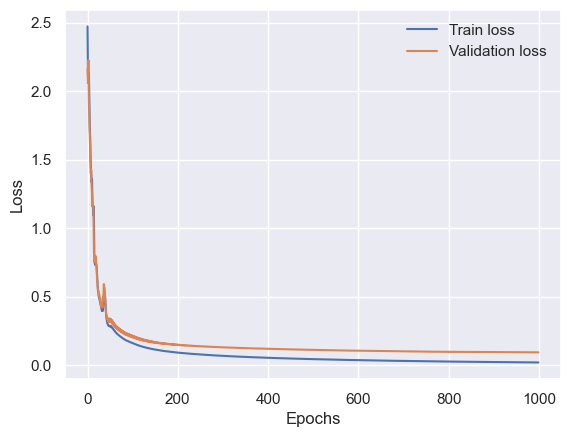

In [39]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

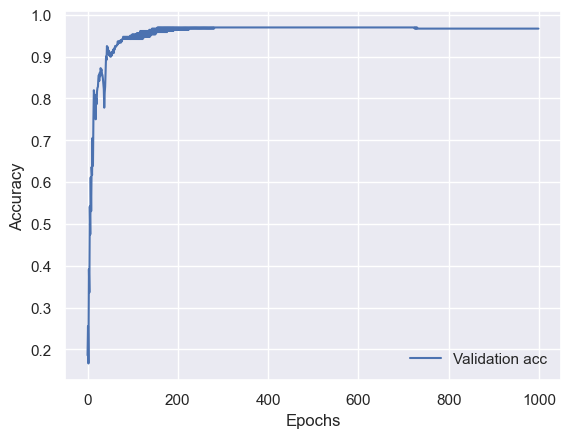

In [40]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    AvgPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    TanH(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.17662400678295848 val loss: 0.21774258140332634 val eval_fn: 0.95
Epoch 200: train loss: 0.11005487816182961 val loss: 0.1627794828780602 val eval_fn: 0.9611111111111111
Epoch 300: train loss: 0.08189265257653754 val loss: 0.14027686995104238 val eval_fn: 0.9638888888888889
Epoch 400: train loss: 0.0650702420986932 val loss: 0.12654312226030093 val eval_fn: 0.9666666666666667
Epoch 500: train loss: 0.053511088055777936 val loss: 0.11658635295611267 val eval_fn: 0.9722222222222222
Epoch 600: train loss: 0.04496734412167221 val loss: 0.10882624332758793 val eval_fn: 0.9722222222222222
Epoch 700: train loss: 0.038379791832198494 val loss: 0.10264910865440637 val eval_fn: 0.9722222222222222
Epoch 800: train loss: 0.03316921111490705 val loss: 0.09772938700164373 val eval_fn: 0.9722222222222222
Epoch 900: train loss: 0.028981422861084526 val loss: 0.09382893904849432 val eval_fn: 0.9694444444444444
Epoch 1000: train loss: 

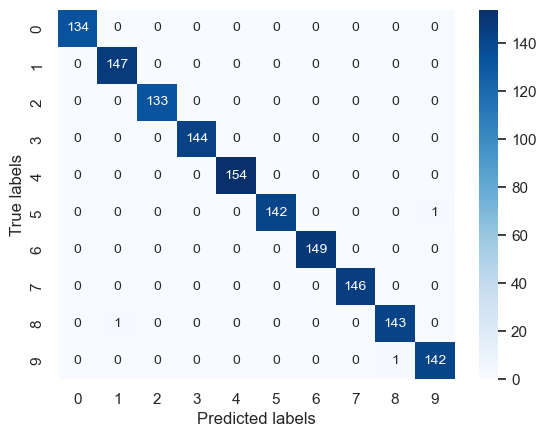

In [42]:
plot_confusion_matrix(net, X_train, y_train)

In [43]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9979123173277662


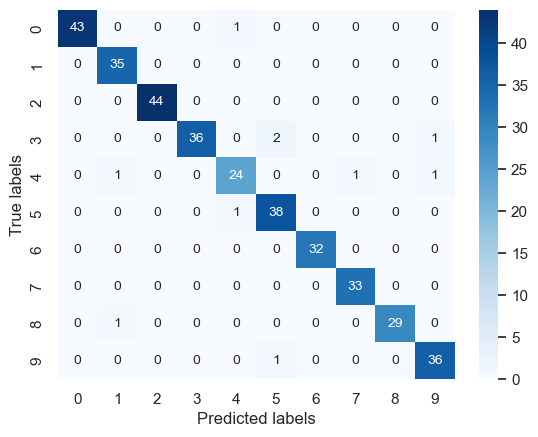

In [44]:
plot_confusion_matrix(net, X_test, y_test)

In [45]:
print('Train accuracy :', eval_fn(net, X_test, y_test_onehot))

Train accuracy : 0.9722222222222222


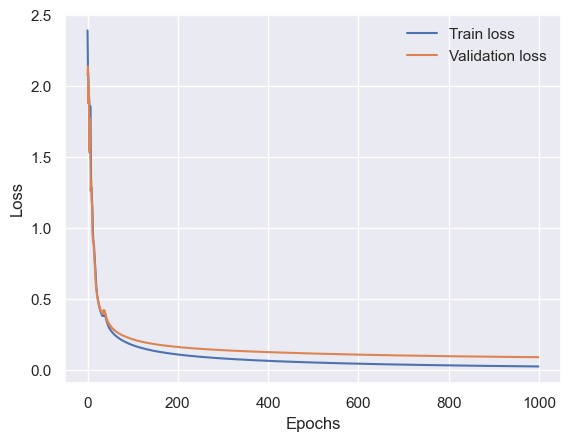

In [46]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

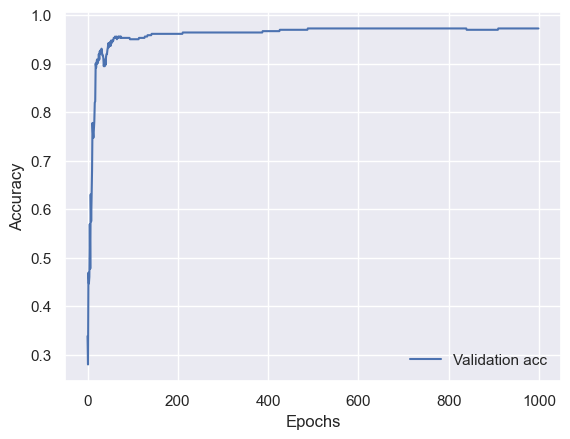

In [47]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()